In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle
import simplekml

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time
import tensorflow as tf


def classifier(base_model, recognizer, labels, image_input):
    weight, height, dim = base_model.input.shape[1], base_model.input.shape[2], base_model.input.shape[3]
    Im_resize = cv2.resize(image_input, (weight, height), interpolation = cv2.INTER_AREA)
    vec = base_model.predict(tf.keras.backend.expand_dims(Im_resize,0)).flatten()
    prob = recognizer.predict_proba([vec])[0]
    return labels.classes_[np.argmax(prob)], prob[np.argmax(prob)]
    

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Parameters

In [8]:
path_T = "Los_Loros/TH_02_index_thermal_ir.tif"


ZonaPV = 'Test'
path_kml_panel = 'Los_Loros/KML/Paneles_' + ZonaPV +'.kml'
path_kml_mesa ='Los_Loros/KML/Mesa_' + ZonaPV +'.kml'
path_dict = 'Los_Loros/KML/Mesa_' + ZonaPV + '.pickle'
path_new_dict = 'Los_Loros/KML/Mesa_' + ZonaPV + '_classifier.pickle'


GR_T.raster.data[GR_T.raster.data == -10000] = 0
GR_T = gr.from_file(path_T)
geot_T = GR_T.geot
## Load List in coordinate latitud and longitude ###
with open(path_dict, "rb") as fp:
    L_strings_coord = pickle.load(fp)

# Load Classifier

In [9]:
path_dataset = './Classifier/Data_set_2/Data_prueba_0/' 
output_recognizer = path_dataset + "model_SVM/recognizer.pickle"
output_label = path_dataset + "model_SVM/le.pickle"


img_width, img_height = 224, 224
base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

x = base_model.output
x  = tf.keras.layers.GlobalAveragePooling2D()(x)
base_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
recognizer_SVM = pickle.loads(open(output_recognizer, "rb").read())
le = pickle.loads(open(output_label, "rb").read())

# Classifier each panel

1
2
3
4
5
6
7
8


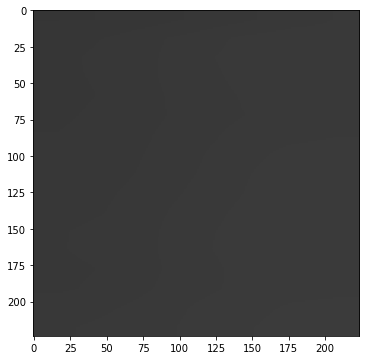

In [17]:

epsilon = -2
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]

for string_key in L_strings_coord.keys():
    print(string_key)
    string = L_strings_coord[string_key]
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        Points =  Utils.gps2pixel(panel['points'], geot_T) + matrix_expand_bounds
        
        if not GR_T.raster.data[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]].size == 0:
            Im = np.zeros((img_height, img_width, 3))
            Im[:,:,0] = cv2.resize(GR_T.raster.data[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]], (img_width, img_height))
            Im[:,:,1] = Im[:,:,0].copy()
            Im[:,:,2] = Im[:,:,0].copy()
            panel['status'], panel['prob'] = classifier(base_model, recognizer_SVM, le, Im)
        else:
            print('problem with coords panel: ', string_key, '_', panel_key)

plt.figure(figsize=(6, 6))
plt.imshow(Im.astype(int))

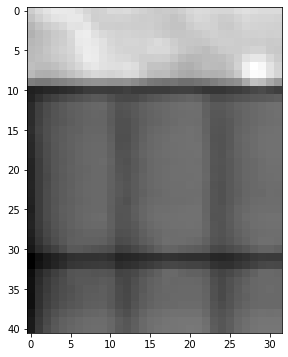

In [18]:
epsilon = 10
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]


panel = string['panels']['2']
Points =  Utils.gps2pixel(panel['points'], geot_T) + matrix_expand_bounds
plt.figure(figsize=(6, 6))
plt.imshow(GR_T.raster.data[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]],cmap = 'gray')


# Save KML Panels

In [19]:

kml=simplekml.Kml()


for string_key in L_strings_coord.keys():
    
    string = L_strings_coord[string_key]
    points = string['points']
    
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        points = panel['points']
        
        pmt = kml.newpolygon(outerboundaryis = points)
        pmt.extendeddata.newdata(name= 'Id integer', value= str(string_key).zfill(3) + '_' + str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name= 'Id panel', value= str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name='Zona PV', value= ZonaPV)
        pmt.extendeddata.newdata(name='Cód. Fall', value= 0)
        pmt.extendeddata.newdata(name= 'Tipo falla', value= panel['status'])
        pmt.extendeddata.newdata(name= 'Mesa', value= string['id'])
        pmt.extendeddata.newdata(name= 'T°', value= panel['T'])
        
kml.save(path_kml_panel)
## Save List in coordinate latitud and longitude ###
with open(path_new_dict, 'wb') as handle:
    pickle.dump(L_strings_coord, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Listo')

Listo


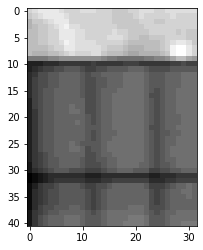

In [20]:
plt.imshow(GR_T.raster.data[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]].astype(int), cmap = 'gray')